<a href="https://colab.research.google.com/github/thalicsouza/previsao_vendas/blob/main/previsao_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configurações Iniciais

In [1]:
# instalando pacotes necessários
!pip install pmdarima
!pip install lifelines
!pip install statsmodels

     |████████████████████████████████| 1.5MB 6.9MB/s 
     |████████████████████████████████| 9.5MB 18.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 5.2MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=40b35e30120171b706eb69ff3a4fd46d63537d15d4e30e7a7afe1c68ce9a052b
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [2]:
# carregando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import math
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

In [3]:
# pacotes para análises temporais
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols, adfuller
from scipy.stats import norm
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow.compat.v2 as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from lifelines import *
from lifelines.plotting import plot_lifetimes
from lifelines.datasets import load_waltons

In [4]:
# upload da base
from google.colab import files
uploaded = files.upload()

Saving sales_db.csv to sales_db.csv


In [5]:
# fazendo a leitura da base
df = pd.read_csv('sales_db.csv', sep=';')
df

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,order_date,creation_date
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1663958,6640.0,209372.0,116238.0,1200397.0,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,50.0,Smart TV,Origin ef2b,"0,0",2016-06-26,2011-03-19
2,1677087,2350.0,141418.0,2821.0,1083764.0,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,60.0,Smart TV,Origin ef2b,"0,0",2016-06-26,2010-07-05
3,2017360,35669.0,618642.0,618642.0,1436106.0,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,"0,0",2016-06-26,2012-06-13
4,2017379,57998.0,1164511.0,70388.0,1436118.0,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,50.0,Smart TV,Origin ef2b,"0,0",2016-06-26,2013-05-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599824,14011995,238362.0,7586641.0,7586641.0,5736172.0,2016-06-30 23:59:57,2016-06-16 12:10:46,Phisical book,Personal finance,-0.345361,0.0,eReaders,Origin 3022,"0,0",2016-06-30,2016-06-16
1599825,14012431,61279.0,589022.0,589022.0,946067.0,2016-06-30 21:40:11,2013-06-15 16:41:06,Phisical book,Personal finance,-0.471786,0.0,Smart TV,Origin ef2b,"0,0",2016-06-30,2013-06-15
1599826,14343996,215242.0,1186145.0,1186145.0,6473172.0,2016-05-13 16:45:42,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0",2016-05-13,2016-03-26
1599827,14344113,215242.0,1186145.0,1186145.0,6473172.0,2016-06-22 14:39:05,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0",2016-06-22,2016-03-26


Análise Exploratória

In [6]:
# tamamho da base: linhas X colunas
df.shape

(1599829, 16)

In [7]:
# formato dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599829 entries, 0 to 1599828
Data columns (total 16 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   purchase_id                      1599829 non-null  int64  
 1   product_id                       1599828 non-null  float64
 2   affiliate_id                     1599828 non-null  float64
 3   producer_id                      1599828 non-null  float64
 4   buyer_id                         1599828 non-null  float64
 5   purchase_date                    1599828 non-null  object 
 6   product_creation_date            1599828 non-null  object 
 7   product_category                 1599828 non-null  object 
 8   product_niche                    1599828 non-null  object 
 9   purchase_value                   1599828 non-null  float64
 10  affiliate_commission_percentual  1599828 non-null  float64
 11  purchase_device                  1599828 non-null 

In [ ]:
# conferindo a existência de valores nulos por coluna
df.isnull().sum()

purchase_id                        0
product_id                         1
affiliate_id                       1
producer_id                        1
buyer_id                           1
purchase_date                      1
product_creation_date              1
product_category                   1
product_niche                      1
purchase_value                     1
affiliate_commission_percentual    1
purchase_device                    1
purchase_origin                    1
is_origin_page_social_network      0
order_date                         1
creation_date                      1
dtype: int64

In [ ]:
# verificando a linha que possui o dado faltante
df[df['product_id'].isnull()]

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,order_date,creation_date
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [ ]:
# excluindo a amostra com valores nulos
df.dropna(inplace=True)

In [ ]:
# conferindo a existência de valores nulos total
df.isnull().sum().sum()

0

In [ ]:
# conferindo a existência de valores nulos por coluna
df.isna().sum()

purchase_id                        0
product_id                         0
affiliate_id                       0
producer_id                        0
buyer_id                           0
purchase_date                      0
product_creation_date              0
product_category                   0
product_niche                      0
purchase_value                     0
affiliate_commission_percentual    0
purchase_device                    0
purchase_origin                    0
is_origin_page_social_network      0
order_date                         0
creation_date                      0
dtype: int64

In [ ]:
# fazendo transformação de colunas para int
df['is_origin_page_social_network'] = df['is_origin_page_social_network'].str.replace(',','.')
df['is_origin_page_social_network'] = df['is_origin_page_social_network'].astype(float)
df['product_id'] = df['product_id'].astype(int)
df['affiliate_id'] = df['affiliate_id'].astype(int)
df['producer_id'] = df['producer_id'].astype(int)
df['buyer_id'] = df['buyer_id'].astype(int)
print('Ok!')
df.info()

Ok!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599828 entries, 1 to 1599828
Data columns (total 16 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   purchase_id                      1599828 non-null  int64  
 1   product_id                       1599828 non-null  int64  
 2   affiliate_id                     1599828 non-null  int64  
 3   producer_id                      1599828 non-null  int64  
 4   buyer_id                         1599828 non-null  int64  
 5   purchase_date                    1599828 non-null  object 
 6   product_creation_date            1599828 non-null  object 
 7   product_category                 1599828 non-null  object 
 8   product_niche                    1599828 non-null  object 
 9   purchase_value                   1599828 non-null  float64
 10  affiliate_commission_percentual  1599828 non-null  float64
 11  purchase_device                  1599828 non-n

In [ ]:
# estatísticas gerais da base
df.describe().T

,count,mean,std,min,25%,50%,75%,max
purchase_id,1599828.0,1.244546e+07,9.175820e+05,1.663958e+06,1.165374e+07,1.246849e+07,1.323310e+07,1.435720e+07
product_id,1599828.0,1.485958e+05,5.554317e+04,4.000000e+00,1.121380e+05,1.543100e+05,1.939340e+05,3.191290e+05
affiliate_id,1599828.0,2.297501e+06,2.092656e+06,3.000000e+00,4.422410e+05,1.690428e+06,3.992235e+06,7.700836e+06
producer_id,1599828.0,2.164480e+06,2.038960e+06,3.000000e+00,4.095900e+05,1.377289e+06,3.776238e+06,9.868481e+06
buyer_id,1599828.0,5.187551e+06,2.199257e+06,6.000000e+01,3.730213e+06,5.999154e+06,6.946337e+06,1.201479e+07
purchase_value,1599828.0,1.248495e-08,1.000000e+00,-5.412400e-01,-4.530150e-01,-3.499980e-01,6.492290e-02,1.245610e+02
affiliate_commission_percentual,1599828.0,7.597402e+00,1.847787e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
is_origin_page_social_network,1599828.0,2.303435e-02,1.500126e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


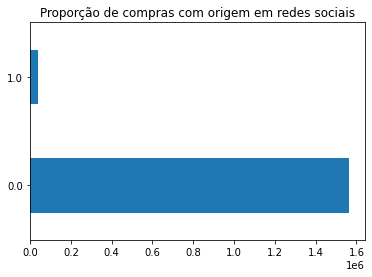

In [ ]:
# verificando a proporção de clientes que vieram ou não de redes sociais
df['is_origin_page_social_network'].value_counts().plot(kind='barh')
plt.title('Proporção de compras com origem em redes sociais')
plt.show();

In [8]:
# verificando a proporção de clientes que vieram ou não de redes sociais
df['is_origin_page_social_network'].value_counts()

0,0    1562977
1,0      36851
0            1
Name: is_origin_page_social_network, dtype: int64

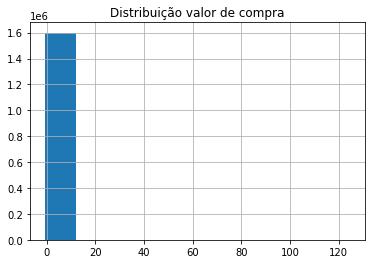

In [ ]:
# distribuição de vendas
df['purchase_value'].hist()
plt.title('Distribuição valor de compra')
plt.show();

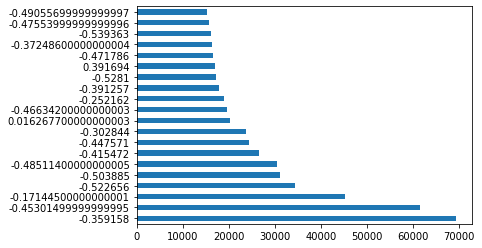

In [ ]:
# distribuição de vendas
df['purchase_value'].value_counts().head(20).plot(kind='barh')
plt.show();

In [ ]:
# distribuição de vendas
df['purchase_value'].describe()

count    1.599828e+06
mean     1.248495e-08
std      1.000000e+00
min     -5.412400e-01
25%     -4.530150e-01
50%     -3.499980e-01
75%      6.492290e-02
max      1.245610e+02
Name: purchase_value, dtype: float64

In [ ]:
# criando uma coluna com os valores de compra acrescidos de 10, para eliminar o efeito dos valores negativos
df['purchase_val_transformed'] = df['purchase_value'] +10
df

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,order_date,creation_date,purchase_val_transformed
1,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2011-03-19,9.734698
2,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,60.0,Smart TV,Origin ef2b,0.0,2016-06-26,2010-07-05,9.822923
3,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,0.0,2016-06-26,2012-06-13,9.531011
4,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2013-05-07,9.598832
5,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2013-05-12,9.547511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599824,14011995,238362,7586641,7586641,5736172,2016-06-30 23:59:57,2016-06-16 12:10:46,Phisical book,Personal finance,-0.345361,0.0,eReaders,Origin 3022,0.0,2016-06-30,2016-06-16,9.654639
1599825,14012431,61279,589022,589022,946067,2016-06-30 21:40:11,2013-06-15 16:41:06,Phisical book,Personal finance,-0.471786,0.0,Smart TV,Origin ef2b,0.0,2016-06-30,2013-06-15,9.528214
1599826,14343996,215242,1186145,1186145,6473172,2016-05-13 16:45:42,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,0.0,2016-05-13,2016-03-26,9.640842
1599827,14344113,215242,1186145,1186145,6473172,2016-06-22 14:39:05,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,0.0,2016-06-22,2016-03-26,9.640842


In [ ]:
# distribuição de vendas transformadas
df['purchase_val_transformed'].describe()

count    1.599828e+06
mean     1.000000e+01
std      1.000000e+00
min      9.458760e+00
25%      9.546985e+00
50%      9.650002e+00
75%      1.006492e+01
max      1.345610e+02
Name: purchase_val_transformed, dtype: float64

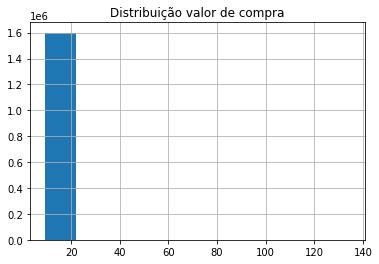

In [ ]:
# distribuição de vendas transformadas
df['purchase_val_transformed'].hist()
plt.title('Distribuição valor de compra')
plt.show();

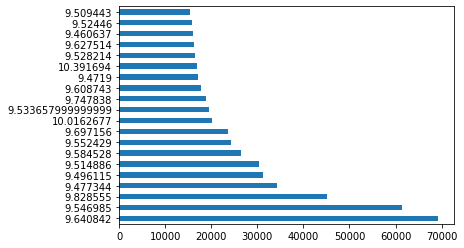

In [ ]:
# distribuição de vendas transformadas
df['purchase_val_transformed'].value_counts().head(20).plot(kind='barh')
plt.show();

In [ ]:
# distribuição das comissões dos afiliados
df['affiliate_commission_percentual'].describe()

count    1.599828e+06
mean     7.597402e+00
std      1.847787e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: affiliate_commission_percentual, dtype: float64

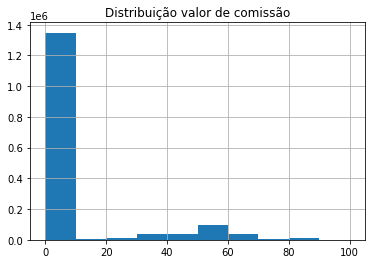

In [ ]:
# distribuição das comissões dos afiliados
df['affiliate_commission_percentual'].hist()
plt.title('Distribuição valor de comissão')
plt.show();

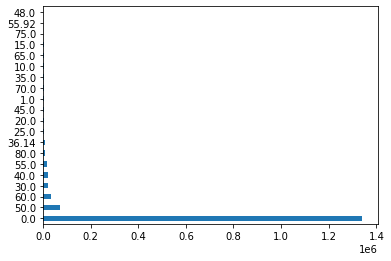

In [ ]:
# distribuição das comissões dos afiliados
df['affiliate_commission_percentual'].value_counts().head(20).plot(kind='barh')
plt.show();

In [ ]:
# ranking dos afiliados com maior proporção de vendas
df_table = df.affiliate_id.value_counts()
df_table = df_table.reset_index()
df_table.columns = ['afiliado','vendas']
df_table['%_vendas'] = (df_table['vendas'] / df['purchase_id'].count())*100
df_table.head(20)

,afiliado,vendas,%_vendas
0,6697083,41220,2.576527
1,349701,31969,1.998277
2,166090,24722,1.545291
3,3992235,21437,1.339957
4,464846,17764,1.110369
5,442241,15362,0.960228
6,4580574,15085,0.942914
7,1745680,14100,0.881345
8,42346,13342,0.833965
9,3512,12219,0.763770


In [ ]:
# visão geral dos valores do conjunto de dados
print("Qtdade de afiliados únicos:",df['affiliate_id'].nunique())
print("Qtdade de produtores únicos:",df['producer_id'].nunique())
print("Qtdade de compradores únicos:",df['buyer_id'].nunique())
print("Qtdade de compras únicas:",df['purchase_id'].nunique())
print("Qtdade de produtos únicos:",df['product_id'].nunique())
print("Receita Total:", df['purchase_val_transformed'].sum())
print("Qtdade de origens únicas:",df['purchase_origin'].nunique())
print("Qtdade de devices únicos:",df['purchase_device'].nunique())
print("Qtdade de nichos únicos:",df['product_niche'].nunique())
print("Qtdade de categorias únicas:",df['product_category'].nunique())

Qtdade de afiliados únicos: 22947
Qtdade de produtores únicos: 8020
Qtdade de compradores únicos: 1100649
Qtdade de compras únicas: 1599828
Qtdade de produtos únicos: 17883
Receita Total: 15998280.019973695
Qtdade de origens únicas: 9603
Qtdade de devices únicos: 5
Qtdade de nichos únicos: 25
Qtdade de categorias únicas: 10


In [ ]:
# análises sobre os produtores
df_table = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['producer_id'], 
                                                                                  aggfunc={'purchase_id': np.count_nonzero,
                                                                                           'purchase_val_transformed': np.sum})
df_table = df_table.reset_index()
df_table.columns = ['produtor','vendas','receita_total']
df_table['%_vendas'] = (df_table['vendas'] / df['purchase_id'].count())*100
df_table['%_receita'] = df_table['receita_total'] / df['purchase_val_transformed'].sum() *100
df_table['ticket_medio'] = round((df_table['receita_total'] / df_table['vendas']),2)
df_table['receita_total'] = round(df_table['receita_total'],2)


df_table.sort_values(by='vendas',ascending=False).head(10)

,produtor,vendas,receita_total,%_vendas,%_receita,ticket_medio
7500,6697083,41220,395158.75,2.576527,2.470008,9.59
5002,3992235,39331,379743.50,2.458452,2.373652,9.66
1100,464846,35470,342262.50,2.217113,2.139371,9.65
877,349701,34568,342514.70,2.160732,2.140947,9.91
556,166090,28895,279678.68,1.806132,1.748180,9.68
1054,442241,27798,272007.86,1.737562,1.700232,9.79
3408,2307584,21720,210073.17,1.357646,1.313098,9.67
4415,3382787,20199,192690.83,1.262573,1.204447,9.54
5570,4580574,16386,155324.88,1.024235,0.970885,9.48
1544,671256,16096,158555.78,1.006108,0.991080,9.85


In [ ]:
# análises sobre os produtores
df_vendas_receita = df_table.sort_values(by='vendas',ascending=False).head(10)
df_vendas_receita

,produtor,vendas,receita_total,%_vendas,%_receita,ticket_medio
7500,6697083,41220,395158.75,2.576527,2.470008,9.59
5002,3992235,39331,379743.50,2.458452,2.373652,9.66
1100,464846,35470,342262.50,2.217113,2.139371,9.65
877,349701,34568,342514.70,2.160732,2.140947,9.91
556,166090,28895,279678.68,1.806132,1.748180,9.68
1054,442241,27798,272007.86,1.737562,1.700232,9.79
3408,2307584,21720,210073.17,1.357646,1.313098,9.67
4415,3382787,20199,192690.83,1.262573,1.204447,9.54
5570,4580574,16386,155324.88,1.024235,0.970885,9.48
1544,671256,16096,158555.78,1.006108,0.991080,9.85


In [ ]:
# análises sobre os produtores
print(df_vendas_receita['%_vendas'].sum())
print(df_vendas_receita['%_receita'].sum())

17.607080261128072
17.05189951382858


In [ ]:
# análises sobre os produtores
df_table.sort_values(by='vendas',ascending=False)

,produtor,vendas,receita_total,%_vendas,%_receita,ticket_medio
7500,6697083,41220,395158.75,2.576527,2.470008,9.59
5002,3992235,39331,379743.50,2.458452,2.373652,9.66
1100,464846,35470,342262.50,2.217113,2.139371,9.65
877,349701,34568,342514.70,2.160732,2.140947,9.91
556,166090,28895,279678.68,1.806132,1.748180,9.68
...,...,...,...,...,...,...
4690,3691824,1,10.05,0.000063,0.000063,10.05
4694,3696291,1,9.83,0.000063,0.000061,9.83
712,231498,1,9.55,0.000063,0.000060,9.55
1005,413969,1,9.51,0.000063,0.000059,9.51


In [ ]:
# análises sobre os produtores
df.groupby('producer_id')['buyer_id','product_id','purchase_id'].nunique().sort_values(by='buyer_id', ascending=False).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,buyer_id,product_id,purchase_id
producer_id,,,
6697083,30063,1,41220
349701,26604,35,34568
2307584,21595,2,21720
3382787,19838,5,20199
3992235,18393,5,39331
464846,17768,13,35470
671256,16093,1,16096
1745680,13629,4,14172
166090,10156,8,28895


In [ ]:
# análises sobre os produtores
df.groupby('producer_id')['buyer_id','product_id','purchase_id'].nunique().sort_values(by='product_id', ascending=False).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,buyer_id,product_id,purchase_id
producer_id,,,
4478320,1604,63,2818
1186145,3523,61,5297
760074,138,53,196
4450416,2749,51,3242
5444,425,51,431
1620464,2377,50,2751
3732787,574,49,1931
3457699,6495,43,7910
585144,2037,42,2765


In [9]:
# análises sobre os produtores: taxa de recorrência
df_recorr = df.groupby('producer_id')['buyer_id','product_id','purchase_id'].nunique().sort_values(by='purchase_id', ascending=False).head(20)
df_recorr['tx_recorrencia'] = df_recorr['purchase_id'] / df_recorr['buyer_id']
df_recorr.columns = ['compradores_unicos','produtos_unicos','vendas_totais','tx_recorrencia']
df_recorr.sort_values(by='tx_recorrencia',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,compradores_unicos,produtos_unicos,vendas_totais,tx_recorrencia
producer_id,,,,
442241.0,7682,6,27798,3.618589
4580574.0,4563,1,16386,3.591059
2026525.0,3309,2,10094,3.050468
906263.0,2995,1,9044,3.019699
166090.0,10156,8,28895,2.845116
3512.0,4875,4,12931,2.652513
3992235.0,18393,5,39331,2.138368
464846.0,17768,13,35470,1.996285
34602.0,7517,12,14564,1.937475


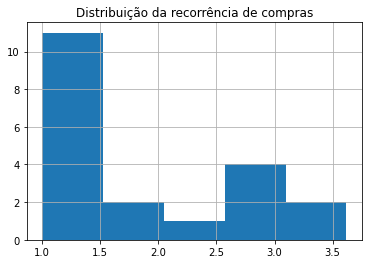

In [11]:
# análises sobre os produtores: taxa de recorrência
df_recorr['tx_recorrencia'].hist(bins=5)
plt.title('Distribuição da recorrência de compras')
plt.show();

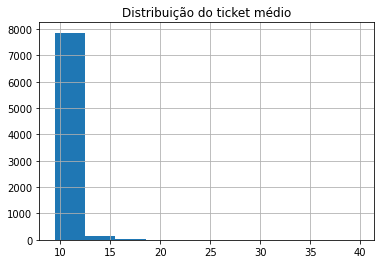

In [ ]:
# análises sobre vendas: ticket médio
df_table['ticket_medio'].hist()
plt.title('Distribuição do ticket médio')
plt.show();

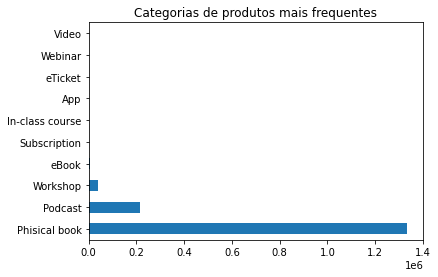

In [ ]:
# análises sobre categorias
df.product_category.value_counts().plot(kind='barh')
plt.title('Categorias de produtos mais frequentes')
plt.show();

In [ ]:
# análises sobre categorias
df_product_category = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['product_category'], 
                                                                                            aggfunc={'purchase_id': np.count_nonzero,
                                                                                                     'purchase_val_transformed': np.sum})

df_product_category = df_product_category.reset_index()
df_product_category.columns = ['categoria','vendas','receita_total']

df_product_category['%_vendas'] = round((df_product_category['vendas']/df_product_category['vendas'].sum() *100),2)
df_product_category['receita_total'] = round(df_product_category['receita_total'],2)
df_product_category['%_receita'] = round((df_product_category['receita_total'] / df['purchase_val_transformed'].sum() *100),2)
df_product_category['ticket_medio'] = round((df_product_category['receita_total'] / df_product_category['vendas']),2)

df_product_category = df_product_category.sort_values(by='%_vendas',ascending=False)

df_product_category

,categoria,vendas,receita_total,%_vendas,%_receita,ticket_medio
2,Phisical book,1334610,13413697.23,83.42,83.84,10.05
3,Podcast,216720,2076434.04,13.55,12.98,9.58
7,Workshop,38246,408120.43,2.39,2.55,10.67
8,eBook,3965,38259.31,0.25,0.24,9.65
4,Subscription,1970,19314.80,0.12,0.12,9.80
0,App,1557,15048.82,0.10,0.09,9.67
1,In-class course,1561,15920.87,0.10,0.10,10.20
9,eTicket,847,8097.57,0.05,0.05,9.56
6,Webinar,295,2809.75,0.02,0.02,9.52
5,Video,57,577.20,0.00,0.00,10.13


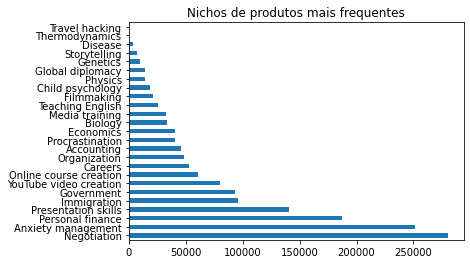

In [12]:
# análises sobre nichos
df.product_niche.value_counts().plot(kind='barh')
plt.title('Nichos de produtos mais frequentes')
plt.show();

In [ ]:
# análises sobre nichos
df_product_niche = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['product_niche'], 
                                                                                         aggfunc={'purchase_id': np.count_nonzero,
                                                                                                  'purchase_val_transformed': np.sum})

df_product_niche = df_product_niche.reset_index()
df_product_niche.columns = ['nicho','vendas','receita_total']

df_product_niche['%_vendas'] = round((df_product_niche['vendas']/df_product_niche['vendas'].sum() *100),2)
df_product_niche['receita_total'] = round(df_product_niche['receita_total'],2)
df_product_niche['%_receita'] = round((df_product_niche['receita_total'] / df['purchase_val_transformed'].sum() *100),2)
df_product_niche['ticket_medio'] = round((df_product_niche['receita_total'] / df_product_niche['vendas']),2)

df_product_niche = df_product_niche.sort_values(by='%_vendas',ascending=False)

df_product_niche

,nicho,vendas,receita_total,%_vendas,%_receita,ticket_medio
13,Negotiation,279921,2785509.95,17.50,17.41,9.95
1,Anxiety management,251675,2505463.04,15.73,15.66,9.96
16,Personal finance,186849,1903377.88,11.68,11.90,10.19
18,Presentation skills,140460,1440358.50,8.78,9.00,10.25
11,Immigration,95660,924308.12,5.98,5.78,9.66
10,Government,93365,905453.58,5.84,5.66,9.70
24,YouTube video creation,80206,781778.16,5.01,4.89,9.75
14,Online course creation,60431,597396.45,3.78,3.73,9.89
3,Careers,52929,555969.90,3.31,3.48,10.50
15,Organization,48632,480817.78,3.04,3.01,9.89


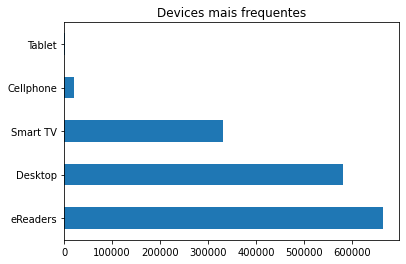

In [ ]:
# análises sobre purchase_device
df.purchase_device.value_counts().plot(kind='barh')
plt.title('Devices mais frequentes')
plt.show();

In [ ]:
# análises sobre purchase_device
df_purchase_device = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['purchase_device'], 
                                                                                         aggfunc={'purchase_id': np.count_nonzero,
                                                                                                  'purchase_val_transformed': np.sum})

df_purchase_device = df_purchase_device.reset_index()
df_purchase_device.columns = ['device','vendas','receita_total']

df_purchase_device['%_vendas'] = round((df_purchase_device['vendas']/df_purchase_device['vendas'].sum() *100),2)
df_purchase_device['receita_total'] = round(df_purchase_device['receita_total'],2)
df_purchase_device['%_receita'] = round((df_purchase_device['receita_total'] / df['purchase_val_transformed'].sum() *100),2)
df_purchase_device['ticket_medio'] = round((df_purchase_device['receita_total'] / df_purchase_device['vendas']),2)

df_purchase_device = df_purchase_device.sort_values(by='%_vendas',ascending=False)

df_purchase_device

,device,vendas,receita_total,%_vendas,%_receita,ticket_medio
4,eReaders,664197,6656705.59,41.52,41.61,10.02
1,Desktop,581900,5923618.16,36.37,37.03,10.18
2,Smart TV,330073,3176822.56,20.63,19.86,9.62
0,Cellphone,20708,211128.86,1.29,1.32,10.20
3,Tablet,2950,30004.86,0.18,0.19,10.17


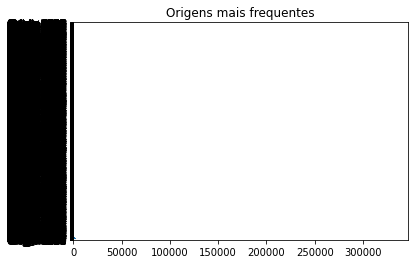

In [ ]:
# análises sobre purchase_origin
df.purchase_origin.value_counts().plot(kind='barh')
plt.title('Origens mais frequentes')
plt.show();

In [ ]:
# análises sobre purchase_origin
df_purchase_origin = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['purchase_origin'], 
                                                                                         aggfunc={'purchase_id': np.count_nonzero,
                                                                                                  'purchase_val_transformed': np.sum})

df_purchase_origin = df_purchase_origin.reset_index()
df_purchase_origin.columns = ['origem','vendas','receita_total']

df_purchase_origin['%_vendas'] = round((df_purchase_origin['vendas']/df_purchase_origin['vendas'].sum() *100),2)
df_purchase_origin['receita_total'] = round(df_purchase_origin['receita_total'],2)
df_purchase_origin['%_receita'] = round((df_purchase_origin['receita_total'] / df['purchase_val_transformed'].sum() *100),2)
df_purchase_origin['ticket_medio'] = round((df_purchase_origin['receita_total'] / df_purchase_origin['vendas']),2)

df_purchase_origin = df_purchase_origin.sort_values(by='%_vendas',ascending=False)

df_purchase_origin.head(15)

,origem,vendas,receita_total,%_vendas,%_receita,ticket_medio
8963,Origin ef2b,330077,3176861.32,20.63,19.86,9.62
2996,Origin 5187,167028,1716864.93,10.44,10.73,10.28
6560,Origin adf0,77857,753694.06,4.87,4.71,9.68
920,Origin 18eb,28693,276151.53,1.79,1.73,9.62
2169,Origin 3ade,13069,126356.04,0.82,0.79,9.67
7742,Origin cf02,12066,126335.52,0.75,0.79,10.47
8110,Origin d8b2,11033,111064.25,0.69,0.69,10.07
7677,Origin cd46,10723,105034.36,0.67,0.66,9.80
6079,Origin a144,10049,98993.21,0.63,0.62,9.85
2050,Origin 3745,9404,91052.36,0.59,0.57,9.68


In [ ]:
# análises sobre buyers
df_buyer_id = pd.pivot_table(df, values=['purchase_id','purchase_val_transformed'], index=['buyer_id'], 
                                                                                    aggfunc={'purchase_id': np.count_nonzero,
                                                                                             'purchase_val_transformed': np.sum})

df_buyer_id = df_buyer_id.reset_index()
df_buyer_id.columns = ['buyer_id','compras','receita_total']

df_buyer_id['%_compras'] = round((df_buyer_id['compras']/df_buyer_id['compras'].sum() *100),2)
df_buyer_id['receita_total'] = round(df_buyer_id['receita_total'],2)
df_buyer_id['%_receita'] = round((df_buyer_id['receita_total'] / df['purchase_val_transformed'].sum() *100),2)
df_buyer_id['ticket_medio'] = round((df_buyer_id['receita_total'] / df_buyer_id['compras']),2)

df_buyer_id = df_buyer_id.sort_values(by='compras',ascending=False)

df_buyer_id.head(15)

,buyer_id,compras,receita_total,%_compras,%_receita,ticket_medio
292054,4763605,66,656.25,0.0,0.0,9.94
40138,701523,62,614.26,0.0,0.0,9.91
8985,158226,62,604.00,0.0,0.0,9.74
18593,336781,59,579.07,0.0,0.0,9.81
66622,1128526,51,569.00,0.0,0.0,11.16
7750,137316,44,422.23,0.0,0.0,9.60
128887,2196492,43,417.49,0.0,0.0,9.71
2240,37734,43,413.28,0.0,0.0,9.61
1902,32277,42,405.10,0.0,0.0,9.65
17436,314082,41,404.99,0.0,0.0,9.88


In [ ]:
# análises sobre buyers
# quantidade média de produtos, categorias, nichos e devices distintos por buyer
df_buyer_id2 = df.groupby('buyer_id')['purchase_id','product_id','product_category','product_niche','purchase_device'].nunique().sort_values(by='product_id', ascending=False)
df_buyer_id2 = df_buyer_id2.reset_index()
df_buyer_id2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,buyer_id,purchase_id,product_id,product_category,product_niche,purchase_device
0,1128526,51,49,3,7,3
1,158226,62,45,3,8,4
2,701523,62,44,4,7,3
3,4763605,66,42,2,5,2
4,37734,43,42,4,5,3
...,...,...,...,...,...,...
1100644,5962244,1,1,1,1,1
1100645,5962245,1,1,1,1,1
1100646,5962247,1,1,1,1,1
1100647,5962248,1,1,1,1,1


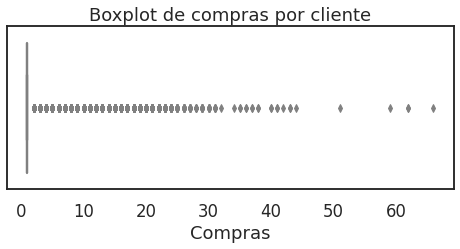

In [ ]:
# análises sobre buyers
# exibindo o boxplot de qtade de compras por cliente
plt.figure(figsize=(8,3))
plt.title("Boxplot de compras por cliente")
sns.boxplot(x="purchase_id", data = df_buyer_id2, orient="h", palette = 'ch:2.5,-.2,dark=.3')
plt.xlabel("Compras")
plt.show();

In [ ]:
# análises sobre buyers
# estatísticas gerais sobre qtade de produtos únicos por cliente
df_buyer_id2['purchase_id'].describe()

count    1.100649e+06
mean     1.453532e+00
std      1.273085e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.600000e+01
Name: purchase_id, dtype: float64

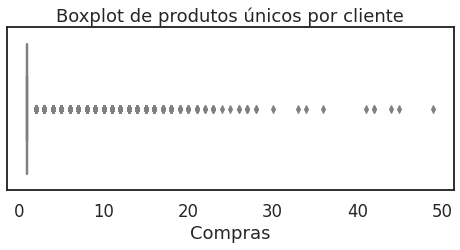

In [ ]:
# análises sobre buyers
# exibindo o boxplot de qtade de produtos únicos por cliente
plt.figure(figsize=(8,3))
plt.title("Boxplot de produtos únicos por cliente")
sns.boxplot(x="product_id", data = df_buyer_id2, orient="h", palette = 'ch:2.5,-.2,dark=.3')
plt.xlabel("Compras")
plt.show();

In [ ]:
# análises sobre buyers
# estatísticas gerais sobre qtade de produtos únicos por cliente
df_buyer_id2['product_id'].describe()

count    1.100649e+06
mean     1.200216e+00
std      6.709769e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.900000e+01
Name: product_id, dtype: float64

In [ ]:
# análises sobre buyers
# quantidade média e mediana de qtade de produtos únicos por cliente
print(df_buyer_id2['product_id'].mean())
print(df_buyer_id2['product_id'].median())

1.2002164177680623
1.0


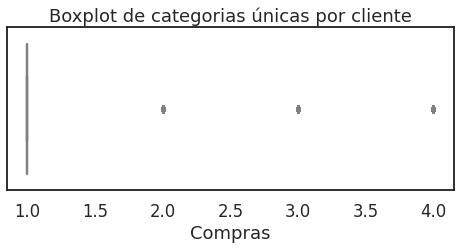

In [ ]:
# análises sobre buyers
# exibindo o boxplot de qtade de categorias únicas por cliente
plt.figure(figsize=(8,3))
plt.title("Boxplot de categorias únicas por cliente")
sns.boxplot(x="product_category", data = df_buyer_id2, orient="h", palette = 'ch:2.5,-.2,dark=.3')
plt.xlabel("Compras")
plt.show();

In [ ]:
# análises sobre buyers
# exibindo o boxplot de qtade de categorias únicas por cliente
df_buyer_id2['product_category'].describe()

count    1.100649e+06
mean     1.042125e+00
std      2.075396e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+00
Name: product_category, dtype: float64

In [ ]:
# análises sobre buyers
# quantidade média e mediana de qtade de categorias únicas por cliente
print(df_buyer_id2['product_category'].mean())
print(df_buyer_id2['product_category'].median())

1.0421251461637633
1.0


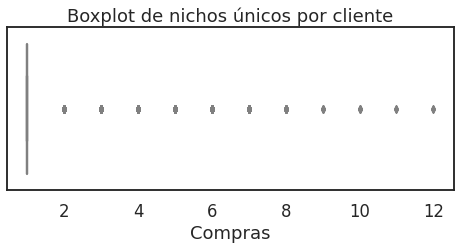

In [ ]:
# análises sobre buyers
# exibindo o boxplot de qtade de nichos únicos por cliente
plt.figure(figsize=(8,3))
plt.title("Boxplot de nichos únicos por cliente")
sns.boxplot(x="product_niche", data = df_buyer_id2, orient="h", palette = 'ch:2.5,-.2,dark=.3')
plt.xlabel("Compras")
plt.show();

In [ ]:
# análises sobre buyerse
df_buyer_id2['product_niche'].describe()

count    1.100649e+06
mean     1.097322e+00
std      3.711076e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.200000e+01
Name: product_niche, dtype: float64

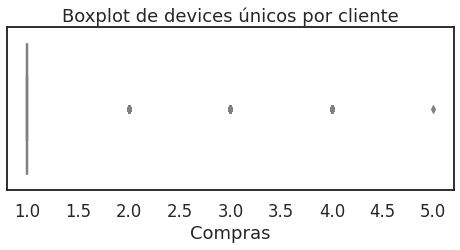

In [ ]:
# análises sobre buyers
plt.figure(figsize=(8,3))
plt.title("Boxplot de devices únicos por cliente")
sns.boxplot(x="purchase_device", data = df_buyer_id2, orient="h", palette = 'ch:2.5,-.2,dark=.3')
plt.xlabel("Compras")
plt.show();

In [ ]:
# análises sobre buyers
df_buyer_id2['purchase_device'].describe()

count    1.100649e+06
mean     1.106653e+00
std      3.303671e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.000000e+00
Name: purchase_device, dtype: float64

In [ ]:
# análises vendas
# datas mínimas e máximas de criação e venda registrados
print('Data mínima de criação:', min(df['creation_date']))
print('Data máxima de criação:', max(df['creation_date']))

print('Data mínima de venda:', min(df['order_date']))
print('Data máxima de venda:', max(df['order_date']))

Data mínima de criação: 2008-10-27
Data máxima de criação: 2016-12-31
Data mínima de venda: 2016-01-01
Data máxima de venda: 2016-06-30


In [ ]:
# análises vendas
# tempo médio de venda do produto
df_product = df.groupby('product_id')['creation_date','order_date'].min()
df_product = df_product.reset_index()

df_product['creation_date'] = pd.to_datetime(df_product['creation_date'])
df_product['order_date'] = pd.to_datetime(df_product['order_date'])
df_product['datediff'] = (df_product['order_date'] - df_product['creation_date'])

df_product

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,product_id,creation_date,order_date,datediff
0,4,2008-10-27,2016-01-19,2640 days
1,17,2008-10-29,2016-03-09,2688 days
2,27,2008-10-31,2016-01-27,2644 days
3,35,2008-11-02,2016-05-15,2751 days
4,39,2008-11-02,2016-05-16,2752 days
...,...,...,...,...
17878,241745,2016-06-28,2016-06-30,2 days
17879,241896,2016-06-29,2016-06-29,0 days
17880,241903,2016-06-29,2016-06-29,0 days
17881,241977,2016-06-29,2016-06-29,0 days


In [ ]:
# análises vendas
df_product.groupby('datediff')['product_id'].count().sort_values(ascending=False).head(20)

datediff
6 days     336
5 days     296
3 days     289
4 days     285
8 days     270
2 days     267
7 days     267
1 days     243
9 days     228
12 days    208
10 days    206
13 days    192
11 days    187
16 days    179
15 days    161
14 days    159
18 days    137
0 days     132
17 days    124
20 days    123
Name: product_id, dtype: int64

In [13]:
# análises vendas
print("Qtdade de produtos únicos:",df['product_id'].nunique())

Qtdade de produtos únicos: 17883


In [ ]:
# análises vendas
df_product['order_date'] = pd.to_datetime(df_product['order_date'])
df_product['weekday'] = df_product['order_date'].dt.day_name()
df_product

,product_id,creation_date,order_date,datediff,weekday
0,4,2008-10-27,2016-01-19,2640 days,Tuesday
1,17,2008-10-29,2016-03-09,2688 days,Wednesday
2,27,2008-10-31,2016-01-27,2644 days,Wednesday
3,35,2008-11-02,2016-05-15,2751 days,Sunday
4,39,2008-11-02,2016-05-16,2752 days,Monday
...,...,...,...,...,...
17878,241745,2016-06-28,2016-06-30,2 days,Thursday
17879,241896,2016-06-29,2016-06-29,0 days,Wednesday
17880,241903,2016-06-29,2016-06-29,0 days,Wednesday
17881,241977,2016-06-29,2016-06-29,0 days,Wednesday


In [ ]:
# análises vendas
# tempo médio de venda do produto
df_weekday = df.groupby('order_date')['purchase_id'].count()
df_weekday = df_weekday.reset_index()
df_weekday['order_date'] = pd.to_datetime(df_weekday['order_date'])
df_weekday['weekday'] = df_weekday['order_date'].dt.day_name()
df_weekday

,order_date,purchase_id,weekday
0,2016-01-01,4378,Friday
1,2016-01-02,7909,Saturday
2,2016-01-03,8080,Sunday
3,2016-01-04,8334,Monday
4,2016-01-05,7938,Tuesday
...,...,...,...
176,2016-06-26,9562,Sunday
177,2016-06-27,9005,Monday
178,2016-06-28,10008,Tuesday
179,2016-06-29,8492,Wednesday


In [ ]:
# análises vendas
# tempo médio de venda do produto
df_weekday = df_weekday.groupby('weekday')['purchase_id'].sum()
df_weekday = df_weekday.reset_index()
df_weekday.columns = ['weekday', 'vendas']
df_weekday.sort_values(by='vendas',ascending=False)

,weekday,vendas
2,Saturday,266326
3,Sunday,254922
5,Tuesday,244935
1,Monday,244063
6,Wednesday,215013
0,Friday,198255
4,Thursday,176314


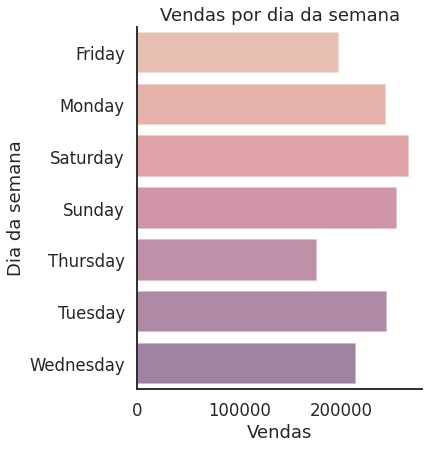

In [ ]:
# análises vendas
# plotando a quantidade de vendas por dia da semana
sns.catplot(data=df_weekday, kind='bar', x='purchase_id', y='weekday', ci="sd", palette='flare',alpha=.6, height=6)
plt.ylabel("Dia da semana")
plt.xlabel("Vendas")
plt.title('Vendas por dia da semana')
plt.show();

Previsão de séres temporais

In [ ]:
df

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,order_date,creation_date,purchase_val_transformed
1,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2011-03-19,9.734698
2,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,60.0,Smart TV,Origin ef2b,0.0,2016-06-26,2010-07-05,9.822923
3,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,0.0,2016-06-26,2012-06-13,9.531011
4,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2013-05-07,9.598832
5,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,50.0,Smart TV,Origin ef2b,0.0,2016-06-26,2013-05-12,9.547511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599824,14011995,238362,7586641,7586641,5736172,2016-06-30 23:59:57,2016-06-16 12:10:46,Phisical book,Personal finance,-0.345361,0.0,eReaders,Origin 3022,0.0,2016-06-30,2016-06-16,9.654639
1599825,14012431,61279,589022,589022,946067,2016-06-30 21:40:11,2013-06-15 16:41:06,Phisical book,Personal finance,-0.471786,0.0,Smart TV,Origin ef2b,0.0,2016-06-30,2013-06-15,9.528214
1599826,14343996,215242,1186145,1186145,6473172,2016-05-13 16:45:42,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,0.0,2016-05-13,2016-03-26,9.640842
1599827,14344113,215242,1186145,1186145,6473172,2016-06-22 14:39:05,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,0.0,2016-06-22,2016-03-26,9.640842


In [14]:
# criando um novo dataframe para armazenar apenas data e quantidade de vendas
df_days = pd.pivot_table(df, values=['purchase_id'], index=['order_date'], 
                                                    aggfunc={'purchase_id': np.count_nonzero})
#df_days = df_days.reset_index()
df_days.columns = ['vendas']
df_days

,vendas
order_date,
2016-01-01,4378
2016-01-02,7909
2016-01-03,8080
2016-01-04,8334
2016-01-05,7938
...,...
2016-06-26,9562
2016-06-27,9005
2016-06-28,10008


In [15]:
df_days.tail(60)

,vendas
order_date,
2016-05-02,16167
2016-05-03,19167
2016-05-04,11133
2016-05-05,8303
2016-05-06,8386
2016-05-07,11658
2016-05-08,11680
2016-05-09,10869
2016-05-10,10270


In [16]:
# exibindo valores mínimos e máximos dessa tabela
df_days = df_days.reset_index()
print('Dia com menor quantidade de vendas:',df_days.min())
print('Dia com maior quantidade de vendas:',df_days.max())
print('Média de vendas por dias:',df_days.mean())

Dia com menor quantidade de vendas: order_date    2016-01-01
vendas              4378
dtype: object
Dia com maior quantidade de vendas: order_date    2016-06-30
vendas             19167
dtype: object
Média de vendas por dias: vendas    8838.828729
dtype: float64


In [17]:
# exibindo o index dessa tabela
df_days.index

RangeIndex(start=0, stop=181, step=1)

In [19]:
# estabelecendo a frequência diária para os valores de data
df_days.index.freq = 'D'
df_days.index

RangeIndex(start=0, stop=181, step=1)

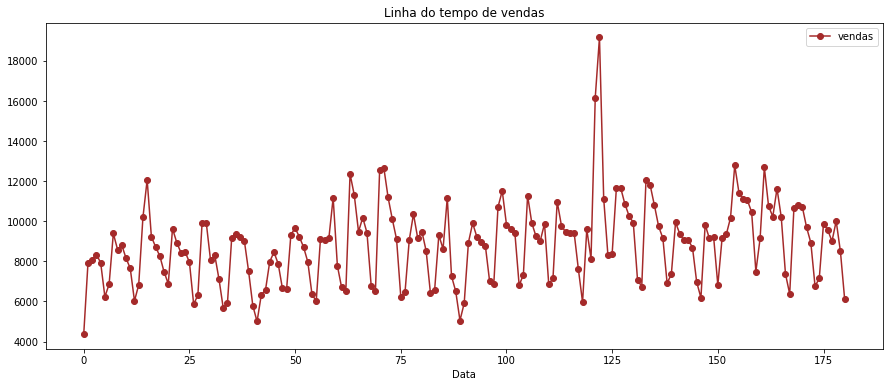

In [20]:
# Plotando o número de vendas
title = 'Linha do tempo de vendas'
ylabel = ''
xlabel = 'Data'

ax=df_days.plot(title=title,figsize=(15,6),marker='o',linestyle='solid',color='brown')
ax.autoscale(axis='both')
ax.set(xlabel=xlabel,ylabel=ylabel)
plt.show()

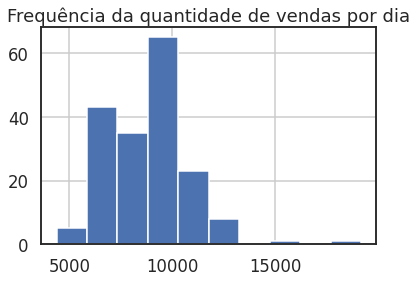

In [ ]:
# histograma de vendas
df_days['vendas'].hist()
plt.title('Frequência da quantidade de vendas por dia');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


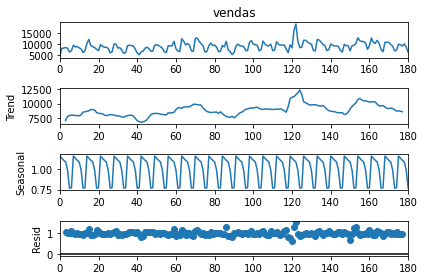

In [25]:
# Decomposição multiplicativa da série temporal
vendas = df_days['vendas']
result2 = seasonal_decompose(vendas,model='multiplicative',freq=7)
fig = result2.plot()
plt.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


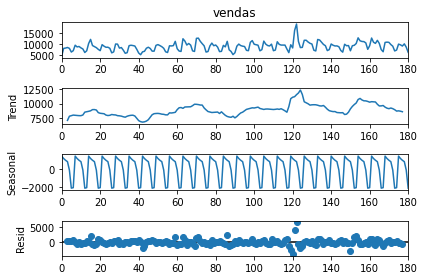

In [26]:
# Decomposição aditiva da série temporal
vendas = df_days['vendas']
result2 = seasonal_decompose(vendas,model='additive',freq=7)
fig = result2.plot()
plt.show();

In [27]:
# Função para cálculo da autocorrelação da série
# autocorrelação total
acf(df_days['vendas'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([ 1.        ,  0.48477704,  0.00600009, -0.10516723, -0.09279013,
       -0.00356366,  0.3058109 ,  0.55502287,  0.27396731, -0.05986541,
       -0.16167197, -0.16373113, -0.03920755,  0.24036109,  0.42569441,
        0.13362492, -0.12551219, -0.19569396, -0.21434683, -0.13403898,
        0.16280128,  0.40144456,  0.17474326, -0.07638824, -0.19980917,
       -0.20377838, -0.10749969,  0.18029793,  0.36737264,  0.16037085,
       -0.02600382, -0.09697804, -0.12066573, -0.07639446,  0.19614463,
        0.45706336,  0.21844676, -0.09891628, -0.16527285, -0.14092778,
       -0.08003346])

In [28]:
# Função para cálculo da autocorrelação da série
# autocorrelação parcial
pacf(df_days['vendas'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1029: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


array([ 1.        ,  0.48747025, -0.30373607,  0.05385057, -0.07155367,
        0.07880519,  0.38071404,  0.34524348, -0.18529691, -0.02907338,
       -0.06942229, -0.09339717,  0.05534391,  0.10211306,  0.11952737,
       -0.21596616,  0.0461009 , -0.07820685, -0.0971631 , -0.086037  ,
        0.12217652,  0.20801464, -0.01985074,  0.0622643 , -0.14558511,
        0.03962182, -0.06019291,  0.14834085,  0.02525424, -0.01279583,
        0.12451537,  0.06415308,  0.04562662, -0.14436511,  0.12597173,
        0.26604915, -0.11753624, -0.26308267,  0.05604256, -0.02117011,
        0.00954569])

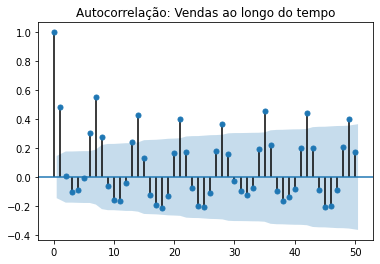

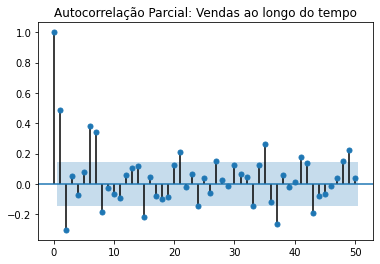

In [29]:
# Correlogramas

# Analisando a autocorrelação - lag 50
title = 'Autocorrelação: Vendas ao longo do tempo'
lags = 50
plot_acf(df_days['vendas'],title=title,lags=lags);

# Analisando a autocorrelação parcial
title = 'Autocorrelação Parcial: Vendas ao longo do tempo'
plot_pacf(df_days['vendas'],title=title,lags=lags);

In [ ]:
# verificando a quantidade amostras da base de treino
df_days.shape[0]*0.75

135.75

In [30]:
# Definindo e separando as bases de treino e teste
train = df_days['vendas'].iloc[:136].astype('float') 
test = df_days['vendas'].iloc[136:].astype('float') 

print('Total de linhas da base de treino: ', train.shape[0],'\n')
print('Total de linhas da base de teste: ', test.shape[0])

Total de linhas da base de treino:  136 

Total de linhas da base de teste:  45


In [31]:
train

0       4378.0
1       7909.0
2       8080.0
3       8334.0
4       7938.0
        ...   
131     7081.0
132     6741.0
133    12033.0
134    11790.0
135    10790.0
Name: vendas, Length: 136, dtype: float64

In [32]:
test

136     9740.0
137     9155.0
138     6913.0
139     7354.0
140     9945.0
141     9367.0
142     9041.0
143     9067.0
144     8690.0
145     6962.0
146     6184.0
147     9825.0
148     9144.0
149     9223.0
150     6819.0
151     9141.0
152     9344.0
153    10171.0
154    12786.0
155    11424.0
156    11114.0
157    11046.0
158    10448.0
159     7494.0
160     9148.0
161    12690.0
162    10760.0
163    10230.0
164    11629.0
165    10208.0
166     7373.0
167     6374.0
168    10665.0
169    10807.0
170    10702.0
171     9691.0
172     8930.0
173     6752.0
174     7161.0
175     9885.0
176     9562.0
177     9005.0
178    10008.0
179     8492.0
180     6111.0
Name: vendas, dtype: float64

In [ ]:
# Definindo e separando as bases de treino e teste
train = df_days['vendas'].iloc[:136].astype('float') 
test = df_days['vendas'].iloc[136:].astype('float') 

print('Total de linhas da base de treino: ', train.shape[0],'\n')
print('Total de linhas da base de teste: ', test.shape[0])

Total de linhas da base de treino:  136 

Total de linhas da base de teste:  45


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


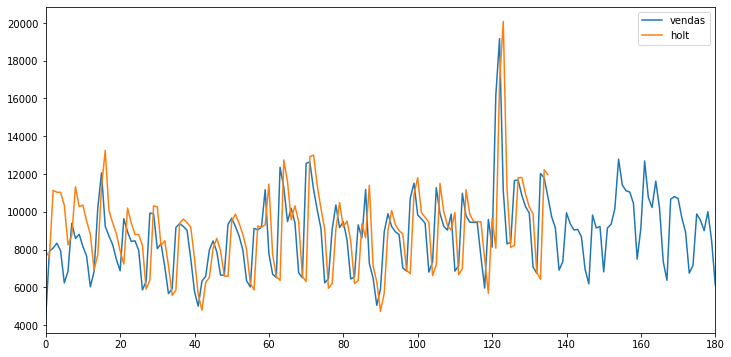

In [33]:
# Previsão de Holt com tendência aditiva
model_holt =  ExponentialSmoothing(train, trend='add')
fit_model = model_holt.fit()

df_days['holt'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt
df_days[['vendas','holt']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
plt.show();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


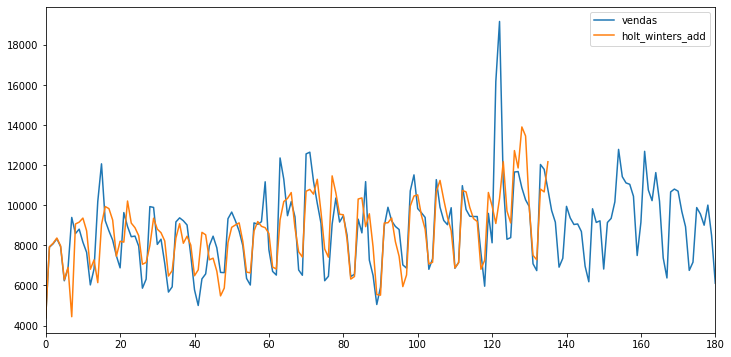

In [34]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade aditiva
model_h_w_add =  ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=7)

fit_model = model_h_w_add.fit()

df_days['holt_winters_add'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt-Winters aditivo
df_days[['vendas','holt_winters_add']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


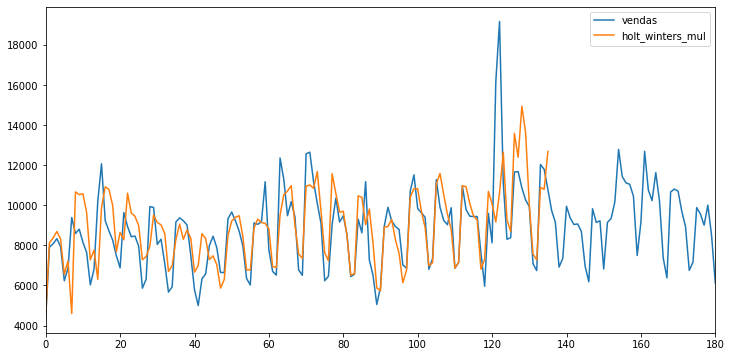

In [35]:
# Prevendo os valores da série de teste com Holt-Winters com sazonalidade e tendência multiplicativa
model_h_w_mul =  ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=7)
fit_model = model_h_w_mul.fit()

df_days['holt_winters_mul'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt-Winters
df_days[['vendas','holt_winters_mul']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

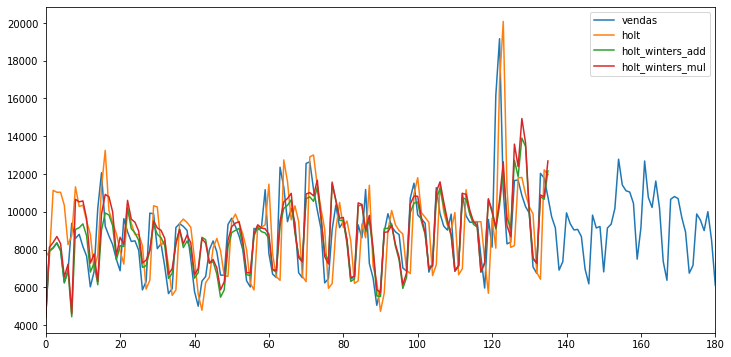

In [36]:
# Visualizando todas os resultados dos modelos Holt e Holt-Winters ajustados
df_days[['vendas','holt','holt_winters_add','holt_winters_mul']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

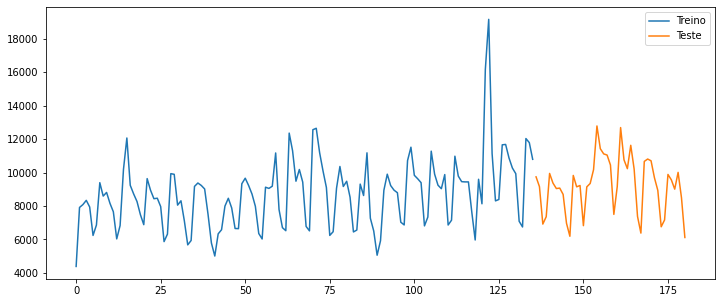

In [37]:
# Visualizando os dados de treino e teste

plt.figure(figsize=(12,5))
train.plot(legend=True, label='Treino')
test.plot(legend=True, label='Teste')
plt.show();


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


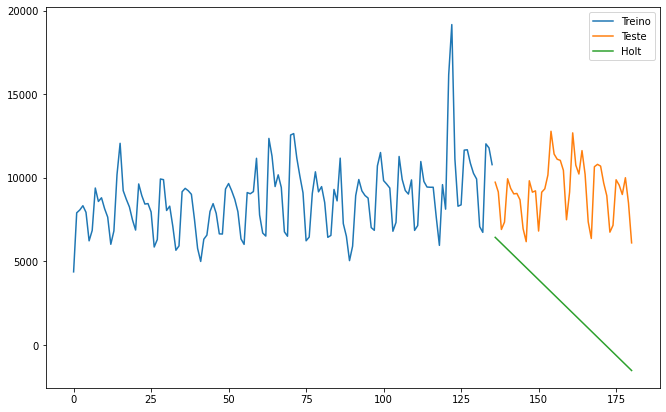

In [38]:
# Prevendo os valoes da série de teste com Holt tendência aditiva
model_holt = ExponentialSmoothing(test, trend='add').fit()
pred_holt = model_holt.forecast(45)

pred_holt.index = df_days['vendas'].index[136:]
df_days['holt'].iloc[136:] = pred_holt

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_holt.plot(legend=True,label='Holt',figsize=(11,7))
plt.show();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


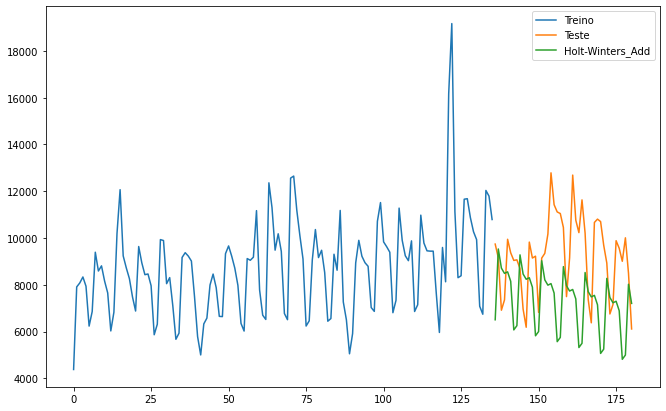

In [40]:
# Prevendo os valoes da série de teste com Holt-Winters com sazonalidade aditiva
model_h_w_add = ExponentialSmoothing(test, trend='add',seasonal='add',seasonal_periods=7).fit()
pred_h_w_add = model_h_w_add.forecast(45)

pred_h_w_add.index = df_days.index[136:]
df_days['holt_winters_add'].iloc[136:] = pred_h_w_add

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_h_w_add.plot(legend=True,label='Holt-Winters_Add',figsize=(11,7));

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


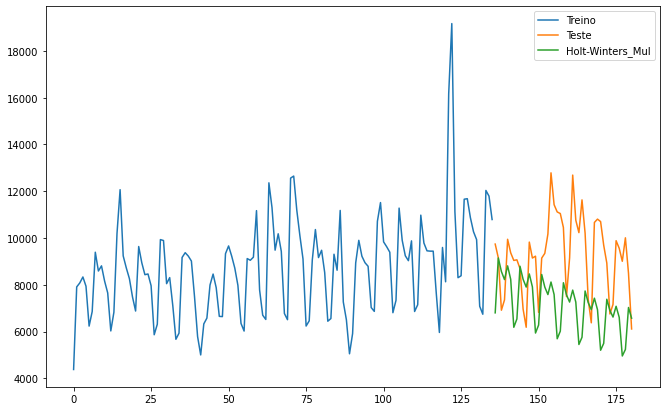

In [41]:
# Prevendo os valores da série de teste com Holt-Winters com sazonalidade multiplicativa
model_h_w_mul = ExponentialSmoothing(test, trend='add',seasonal='mul',seasonal_periods=7).fit()
pred_h_w_mul = model_h_w_mul.forecast(45)

pred_h_w_mul.index = df_days.index[136:]
df_days['holt_winters_mul'].iloc[136:] = pred_h_w_mul

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_h_w_mul.plot(legend=True,label='Holt-Winters_Mul',figsize=(11,7));

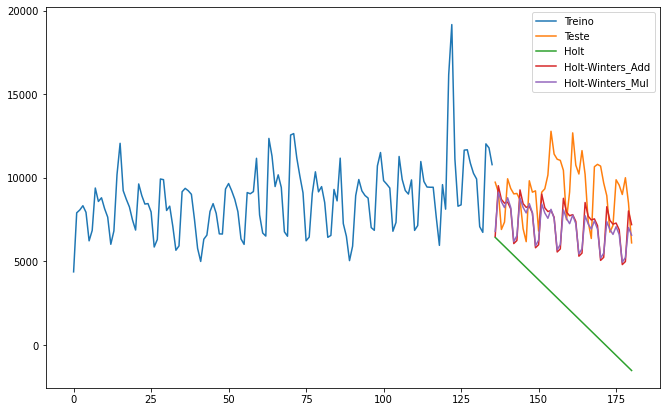

In [42]:
# Visualizando as previsões da série de teste com todos os métodos utilizados
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_holt.plot(legend=True,label='Holt')
pred_h_w_add.plot(legend=True,label='Holt-Winters_Add')
pred_h_w_mul.plot(legend=True,label='Holt-Winters_Mul',figsize=(11,7));

In [43]:
# Criando um DataFrame para armazenar os resultados de MAE e MSE dos métodos utilizados
ind = 'MAE','MSE','RMSE'
metrics = {'Holt':[mean_absolute_error(test,pred_holt),mean_squared_error(test,pred_holt),math.sqrt(mean_squared_error(test,pred_holt))],
           'Holt-Winters_Add':[mean_absolute_error(test,pred_h_w_add),mean_squared_error(test,pred_h_w_add),math.sqrt(mean_squared_error(test,pred_h_w_add))],
           'Holt-Winters_Mul':[mean_absolute_error(test,pred_h_w_mul),mean_squared_error(test,pred_h_w_mul),math.sqrt(mean_squared_error(test,pred_h_w_mul))]}
df_metrics = pd.DataFrame(data=metrics)
df_metrics.index = ind
df_metrics.head()

,Holt,Holt-Winters_Add,Holt-Winters_Mul
MAE,6.796903e+03,2.425428e+03,2.410184e+03
MSE,5.480898e+07,8.876946e+06,8.719138e+06
RMSE,7.403309e+03,2.979420e+03,2.952819e+03


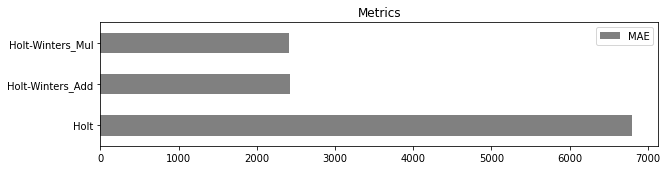

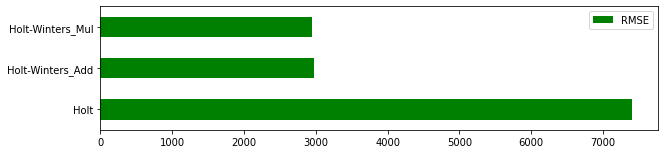

In [44]:
# Plotando os resultados das métricas de avaliação
plt.figure(1)
plt.subplot(211)
df_metrics.loc['MAE'].plot(kind='barh', color='grey', title='Metrics', legend=True, figsize=(10,5))

plt.figure(2)
plt.subplot(212)
df_metrics.loc['RMSE'].plot(kind='barh', color='green', legend=True, figsize=(10,5))

plt.show()

In [45]:
# Escolha de modelo SARIMA com stepwise
np.random.seed(0)
stepwise_fit = auto_arima(df_days['vendas'], start_p=0, start_q=0,
                          max_p=10, max_q=8, m=7,
                          seasonal=True, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True,
                          random_state=0)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3252.121, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3187.184, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3214.419, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3250.128, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3254.128, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=3170.253, Time=0.51 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=3134.277, Time=1.35 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3132.224, Time=1.16 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=3169.274, Time=0.40 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=3186.243, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  181
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -1561.112
Date:                             Mon, 28 Jun 2021   AIC                           3132.224
Time:                                     12:54:54   BIC                           3148.188
Sample:                                          0   HQIC                          3138.697
                                             - 181                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7993      5.940     -0.303      0.762     -13.441       9.842
ar.S.L7        0.9403      0.140      6.726      0.000       0.666       1.214
ar.S.L14       0.0509      0.134      0.381      0.703      -0.211       0.313
ma.S.L7       -0.8909      0.099     -8.997      0.000      -1.085      -0.697
sigma2      1.874e+06   9.51e+04     19.709      0.000    1.69e+06    2.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):              1095.20
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.43e+14. Standard errors may be unstable.
"""

In [46]:
# Utilizando o melhor método indicado na base de treino
model_sarimax_train = SARIMAX(train,simple_differencing=True,order=(0,1,0),seasonal_order=(2,0,1,7))
results_train = model_sarimax_train.fit()
results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            D.vendas   No. Observations:                  135
Model:             SARIMAX(0, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -1182.630
Date:                             Mon, 28 Jun 2021   AIC                           2373.260
Time:                                     12:55:03   BIC                           2384.881
Sample:                                          0   HQIC                          2377.983
                                             - 135                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.0002      0.141      7.070      0.000       0.723       1.277
ar.S.L14      -0.0003      0.141     -0.002      0.998      -0.277       0.277
ma.S.L7       -0.9839      0.055    -18.013      0.000      -1.091      -0.877
sigma2      2.051e+06   4.76e-08   4.31e+13      0.000    2.05e+06    2.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):               845.71
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.21e+29. Standard errors may be unstable.
"""

In [47]:
# Utilizando o melhor método indicado na base de teste
model_sarimax_test = SARIMAX(test,simple_differencing=True,order=(0,1,0),seasonal_order=(2,0,1,7))
results_test = model_sarimax_test.fit()
results_test.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            D.vendas   No. Observations:                   44
Model:             SARIMAX(0, 0, 0)x(2, 0, [1], 7)   Log Likelihood                -375.452
Date:                             Mon, 28 Jun 2021   AIC                            758.904
Time:                                     12:55:06   BIC                            766.041
Sample:                                          0   HQIC                           761.551
                                              - 44                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.0062      0.187      5.392      0.000       0.640       1.372
ar.S.L14      -0.0063      0.186     -0.034      0.973      -0.371       0.359
ma.S.L7       -0.9818      0.284     -3.460      0.001      -1.538      -0.426
sigma2      1.014e+06    2.9e-07    3.5e+12      0.000    1.01e+06    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.58   Prob(JB):                         0.48
Heteroskedasticity (H):               0.69   Skew:                             0.32
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.08e+27. Standard errors may be unstable.
"""

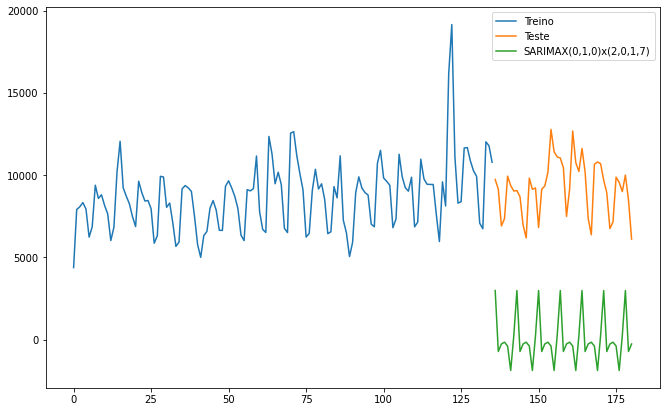

In [48]:
# Obtendo as previsões e comparando com os dados originais

# Base de teste
start = len(train)
end = len(train) + len(test) -1
pred_sarimax = results_test.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(0,1,0)x(2,0,1,7)')
pred_sarimax.index = test.index

# Visualizando as previsões da série de teste
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_sarimax.plot(legend=True,label='SARIMAX(0,1,0)x(2,0,1,7)',figsize=(11,7));

In [49]:
# Criando as previsões do número de mortes com o SARIMAX(3,1,3)x(2,0,1,7)) e incorporando no dataset original
df_days['SARIMAX(0,1,0)x(2,0,1,7)'] = ''
df_days['SARIMAX(0,1,0)x(2,0,1,7)'].iloc[136:] = pred_sarimax

df_days.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,order_date,vendas,holt,holt_winters_add,holt_winters_mul,"SARIMAX(0,1,0)x(2,0,1,7)"
176,2016-06-26,9562,-797.621740,6892.227510,6609.732520,-1882.4
177,2016-06-27,9005,-978.624637,4813.989091,4956.236198,239.251
178,2016-06-28,10008,-1159.627533,4995.936537,5234.940510,2983.25
179,2016-06-29,8492,-1340.630429,8022.162917,7029.165445,-726.657
180,2016-06-30,6111,-1521.633325,7203.738361,6573.034568,-269.457


Previsão com LSTM

In [50]:
# Criando o dataframe da base de teste
df_train = pd.DataFrame(data=train)
df_train.columns = ['vendas']
df_train

,vendas
0,4378.0
1,7909.0
2,8080.0
3,8334.0
4,7938.0
...,...
131,7081.0
132,6741.0
133,12033.0
134,11790.0


In [51]:
# Criando o dataframe da base de teste
df_test = pd.DataFrame(data=test)
df_test.columns = ['vendas']
df_test

,vendas
136,9740.0
137,9155.0
138,6913.0
139,7354.0
140,9945.0
141,9367.0
142,9041.0
143,9067.0
144,8690.0
145,6962.0


In [52]:
# Definindo o padronizador dos meus dados e ajustando a base de treino
print('Padronizando base de treino...')
scaler = MinMaxScaler()
scaler.fit(df_train)
print('Ok')

Padronizando base de treino...
Ok


In [53]:
# verificando os valores após a transformação de escala
scaled_train = scaler.transform(df_train)
print("Valores min e max da base de treino transformada")
print("Min: ",scaled_train.min(),"Max: ",scaled_train.max())
print("\n")
scaled_test = scaler.transform(df_test)
print("Valores min e max da base de teste transformada")
print("Min: ",scaled_test.min(),"Max: ",scaled_test.max())

Valores min e max da base de treino transformada
Min:  0.0 Max:  1.0


Valores min e max da base de teste transformada
Min:  0.11718168909324495 Max:  0.5685306646832105


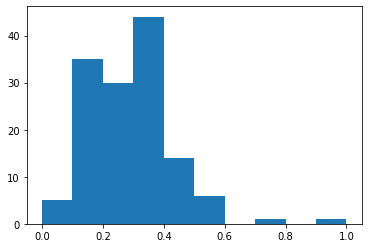

In [54]:
# Histograma da base de treino transformada
plt.hist(scaled_train);

In [55]:
# Definindo configurações para a criação da rede neural que será utilizada
# Nesse caso a rede terá 100 neurônios, e uma única saída. A função de ativação será a Relu, e a função de perda será a Mean Squared Error
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [56]:
model

In [57]:
# Fit do modelo na base de treino
model.fit_generator(generator,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
129/129 [==============================] - 2s 4ms/step - loss: 0.0266
Epoch 2/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 3/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0189
Epoch 4/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0191
Epoch 5/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 6/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 7/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 8/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 9/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 10/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0165
Epoch 11/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 12/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 13/100


In [58]:
model.history.history.keys()

dict_keys(['loss'])

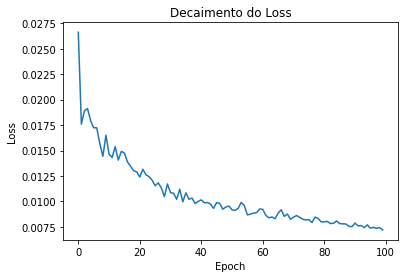

In [59]:
# Plotando o comportamento de perda por época
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Decaimento do Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [60]:
# Avaliação da performance da rede com os dados de teste com 3 lotes contendo 7 observações cada
first_eval_batch = scaled_train[-7:]
first_eval_batch

array([[0.39840422],
       [0.37548178],
       [0.18277098],
       [0.15978092],
       [0.51761444],
       [0.50118331],
       [0.43356549]])

In [61]:
# Ajustando as previsões para o primeiro lote de treino
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

array([[0.41274157]], dtype=float32)

In [62]:
# Ajustando as predições para a base teste
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
current_batch.shape

(1, 7, 1)

In [63]:
# Aplicando a rede neural treinada para o restante da base de teste
print('Fitando a rede para a base de teste...')

np.append(current_batch[:,1:,:],[[[99]]],axis=1)
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

print('Ok')

Fitando a rede para a base de teste...
Ok


In [64]:
print('Pred test: ',test_predictions)

print('Scaled test: ', scaled_test)

Pred test:  [array([0.41274157], dtype=float32), array([0.36325896], dtype=float32), array([0.19139737], dtype=float32), array([0.1408084], dtype=float32), array([0.40641612], dtype=float32), array([0.45781356], dtype=float32), array([0.42767286], dtype=float32), array([0.41042724], dtype=float32), array([0.36196238], dtype=float32), array([0.18922734], dtype=float32), array([0.12841049], dtype=float32), array([0.3852058], dtype=float32), array([0.4493314], dtype=float32), array([0.42492375], dtype=float32), array([0.40847585], dtype=float32), array([0.36164117], dtype=float32), array([0.18916488], dtype=float32), array([0.12719685], dtype=float32), array([0.3789359], dtype=float32), array([0.4464915], dtype=float32), array([0.4241376], dtype=float32), array([0.4076624], dtype=float32), array([0.36158845], dtype=float32), array([0.1892756], dtype=float32), array([0.12703127], dtype=float32), array([0.3768806], dtype=float32), array([0.4455355], dtype=float32), array([0.423904], dtype=f

In [65]:
# Retomando a escala original das predições da base de teste
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[10482.03510335],
       [ 9750.23672783],
       [ 7208.57568878],
       [ 6460.41547924],
       [10388.48797125],
       [11148.60475308],
       [10702.853971  ],
       [10447.80848959],
       [ 9731.06160861],
       [ 7176.48316979],
       [ 6277.06271246],
       [10074.80865461],
       [11023.16211569],
       [10662.19730589],
       [10418.94928727],
       [ 9726.31124234],
       [ 7175.55936503],
       [ 6259.11419088],
       [ 9982.08307406],
       [10981.1629366 ],
       [10650.57085276],
       [10406.9191103 ],
       [ 9725.5315617 ],
       [ 7177.19673845],
       [ 6256.66540307],
       [ 9951.68698853],
       [10967.0246689 ],
       [10647.11628133],
       [10402.6513615 ],
       [ 9725.82201368],
       [ 7178.30830124],
       [ 6256.22531764],
       [ 9941.46343166],
       [10962.32058102],
       [10646.09595308],
       [10401.34587023],
       [ 9726.32578698],
       [ 7178.94429851],
       [ 6256.19688949],
       [ 9938.05205339],


In [66]:
true_predictions.shape

(45, 1)

In [67]:
true_predictions = pd.DataFrame(data=true_predictions)
true_predictions.index = test.index

In [68]:
true_predictions.columns = ['LSTM']
true_predictions

,LSTM
136,10482.035103
137,9750.236728
138,7208.575689
139,6460.415479
140,10388.487971
141,11148.604753
142,10702.853971
143,10447.808490
144,9731.061609
145,7176.483170


In [69]:
# Incorporando as predições no dataframe original
df = pd.merge(df_days, true_predictions, how='left', left_index=True, right_index=True)
df.tail(20)

,order_date,vendas,holt,holt_winters_add,holt_winters_mul,"SARIMAX(0,1,0)x(2,0,1,7)",LSTM
161,2016-06-11,12690,1917.421702,7799.004240,7772.259774,-393.89,9951.686989
162,2016-06-12,10760,1736.418806,7395.019583,7259.326474,-1882.71,10967.024669
163,2016-06-13,10230,1555.415910,5316.781164,5446.770670,239.291,10647.116281
164,2016-06-14,11629,1374.413013,5498.728610,5756.748162,2983.75,10402.651361
165,2016-06-15,10208,1193.410117,8524.954990,7734.841901,-726.777,9725.822014
166,2016-06-16,7373,1012.407221,7706.530434,7237.684986,-269.502,7178.308301
167,2016-06-17,6374,831.404325,7481.288170,6939.969343,-159.981,6256.225318
168,2016-06-18,10665,650.401429,7547.608204,7426.721704,-393.857,9941.463432
169,2016-06-19,10807,469.398533,7143.623546,6934.529497,-1882.56,10962.320581
170,2016-06-20,10702,288.395636,5065.385128,5201.503434,239.271,10646.095953


In [70]:
# Salvando a rede criada
model.save('rnn_lstm.h5')
print('Ok')

Ok


In [80]:
# Criando um DataFrame para armazenar os resultados de MAE e MSE dos métodos utilizados
ind = 'MAE','MSE','RMSE'
metrics = {'Holt':[mean_absolute_error(test,pred_holt),mean_squared_error(test,pred_holt),math.sqrt(mean_squared_error(test,pred_holt))],
           'Holt-Winters_Add':[mean_absolute_error(test,pred_h_w_add),mean_squared_error(test,pred_h_w_add),math.sqrt(mean_squared_error(test,pred_h_w_add))],
           'Holt-Winters_Mul':[mean_absolute_error(test,pred_h_w_mul),mean_squared_error(test,pred_h_w_mul),math.sqrt(mean_squared_error(test,pred_h_w_mul))],
           'SARIMAX(0,1,0)x(2,0,1,7)':[mean_absolute_error(test,pred_sarimax),mean_squared_error(test,pred_sarimax),math.sqrt(mean_squared_error(test,pred_sarimax))]}
df_metrics = pd.DataFrame(data=metrics)
df_metrics.index = ind
df_metrics.head()

,Holt,Holt-Winters_Add,Holt-Winters_Mul,"SARIMAX(0,1,0)x(2,0,1,7)"
MAE,6.796903e+03,2.425428e+03,2.410184e+03,9.241132e+03
MSE,5.480898e+07,8.876946e+06,8.719138e+06,9.006585e+07
RMSE,7.403309e+03,2.979420e+03,2.952819e+03,9.490303e+03


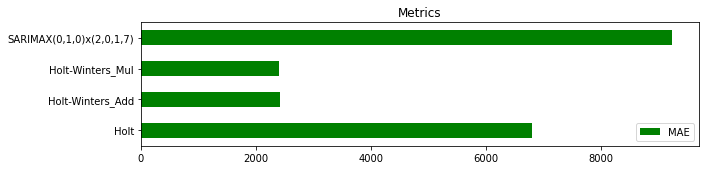

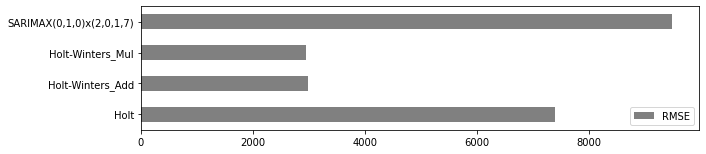

In [81]:
# Plotando os resultados das métricas de avaliação
plt.figure(1)
plt.subplot(211)
df_metrics.loc['MAE'].plot(kind='barh', color='green', title='Metrics', legend=True, figsize=(10,5))

plt.figure(2)
plt.subplot(212)
df_metrics.loc['RMSE'].plot(kind='barh', color='gray', legend=True, figsize=(10,5))

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


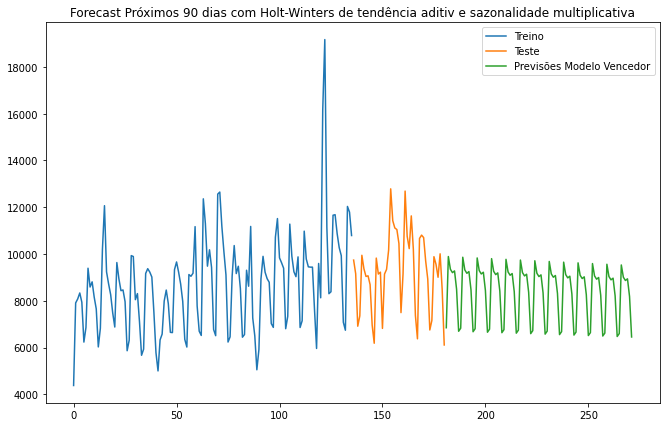

In [74]:
# Criando o forecast dos próximos dias com o modelo vencedor
modelo_vencedor = ExponentialSmoothing(df_days['vendas'], trend='add',seasonal='mul',seasonal_periods=7)
resultados = modelo_vencedor.fit()
fcast = resultados.predict(len(df_days),len(df_days)+90).rename('Previsões Modelo Vencedor')

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
fcast.plot(legend=True,label='Previsões Modelo Vencedor',figsize=(11,7),title='Forecast Próximos 90 dias com Holt-Winters de tendência aditiv e sazonalidade multiplicativa');

In [76]:
fcast

181    6847.576410
182    9891.621259
183    9347.221758
184    9203.020360
185    9277.712043
          ...     
267    9006.576454
268    8867.484685
269    8939.306280
270    8184.021392
271    6452.199124
Name: Previsões Modelo Vencedor, Length: 91, dtype: float64

In [77]:
# Salvando o arquivo do dataframe original + previsões de todos os modelos
df.to_csv('df_final.csv', index=True)
print('done')

done


In [78]:
# Salvando o arquivo com as previsões para os próximos 90 dias com o modelo vencedorf
fcast.to_csv('fcast.csv', index=True)
print('done')

done
